<a href="https://colab.research.google.com/github/anupamavm/FYP-Model/blob/main/Formatting_Mobilenetv2_b%3D16%2Cw%3D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

pip -q install vit_keras tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.2 MB/s eta 0:00:00


In [3]:
!pip install vit-keras


In [4]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from vit_keras import vit
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



import cv2
import random
import warnings
import pandas as pd
from termcolor import colored

from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix



import tensorflow as tf
tf.get_logger().setLevel('ERROR')



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet

In [10]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [11]:

# Define the path to the directory containing your dataset
directory_path = '/content/drive/My Drive/Tea-Diseases-Data'

# List all files in the directory
files = os.listdir(directory_path)

# Print the list of files
print(files)


['validation', 'test', 'valid', 'train']


In [12]:
SEED = 42
np.random.seed(SEED)


In [13]:
# Insert the Dataset path here
train_path = '/content/drive/MyDrive/Tea-Diseases-Data/train'
val_path = '/content/drive/MyDrive/Tea-Diseases-Data/validation'
test_path = '/content/drive/MyDrive/Tea-Diseases-Data/test'

In [14]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4
WIDTH_MULTIPLIER = 1

In [15]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   brightness_range=[0.8, 1.4],
                                   vertical_flip=True,
                                   horizontal_flip=True)


val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')



validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')



test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 725 images belonging to 8 classes.
Found 82 images belonging to 8 classes.
Found 83 images belonging to 8 classes.


In [17]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_path)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))


In [18]:
num_of_classes(train_path, 'train')
num_of_classes(val_path, 'validation')
num_of_classes(test_path, 'test')

number of classes in train folder : 8
number of classes in validation folder : 8
number of classes in test folder : 8


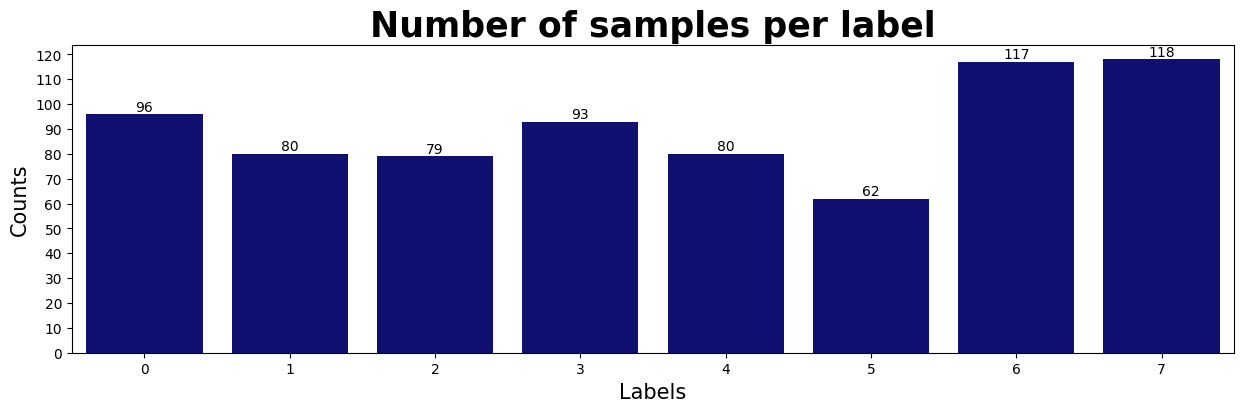

In [19]:
# Get the class names and the number of samples in each class
classes = [class_name for class_name in os.listdir(train_path)]
count = [len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes]

# Convert class names to integers if they are in string format and sort them
sorted_classes = sorted(classes, key=int)
sorted_count = [count[classes.index(class_name)] for class_name in sorted_classes]

# Plot the sorted class counts
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=sorted_classes, y=sorted_count, color='navy')
plt.xticks(rotation=0)  # No rotation needed if class names are integers
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, max(sorted_count) + 10, 10))
plt.show()

In [20]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df


train_df = create_df(train_path)
validation_df = create_df(val_path)
test_df = create_df(test_path)

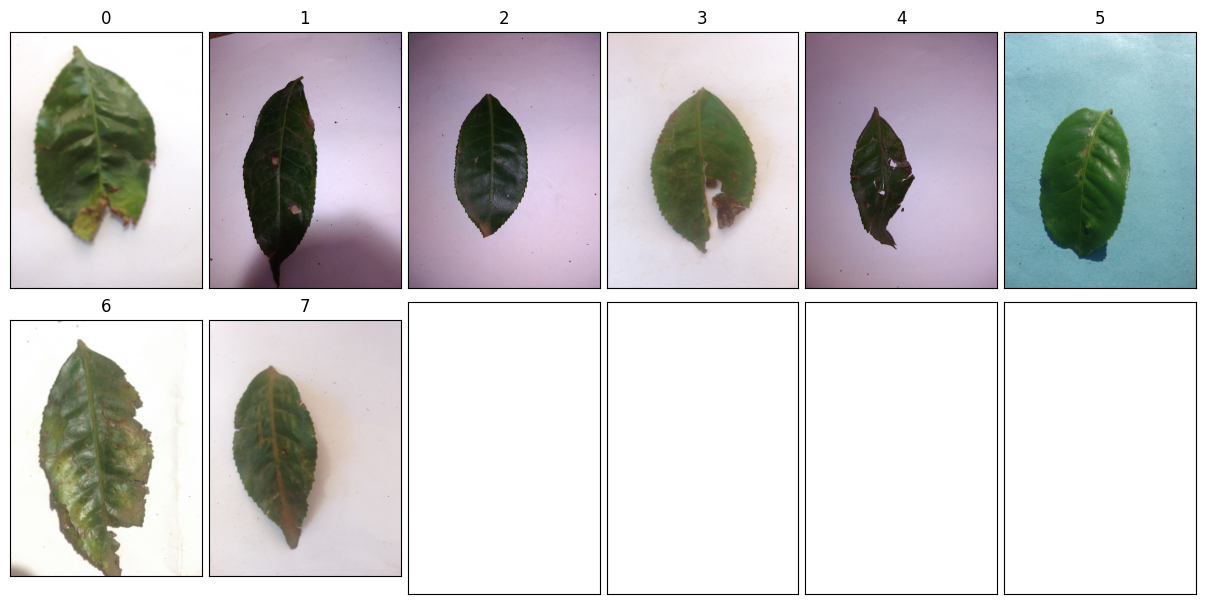

In [21]:
# Assuming train_df is already defined and contains the necessary data
# Ensure the classes are sorted
train_df_sorted = train_df.copy()
train_df_sorted['label'] = train_df_sorted['label'].astype(int)  # Convert labels to integers if needed
train_df_sorted = train_df_sorted.sort_values(by='label').reset_index(drop=True)

# Create a DataFrame with one Label of each category
df_unique = train_df_sorted.drop_duplicates(subset=["label"]).reset_index(drop=True)

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):  # Check if index is within the DataFrame length
        img = plt.imread(df_unique.file_path[i])
        ax.imshow(img)
        ax.set_title(df_unique.label[i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

In [22]:
from tensorflow.keras.applications import MobileNetV2

In [23]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

9406464/9406464 [==============================] - 0s 0us/step


In [24]:

# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)




input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [25]:

# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model
from tensorflow.keras.models import Model
pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False


In [26]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

In [27]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 2619848 (9.99 MB)
Trainable params: 1247944 (4.76 MB)
Non-trainable params: 1371904 (5.23 MB)
______________

In [28]:

import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [29]:

 model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [30]:
#Define the directory for saving model artifacts
save_dir = '/content/drive/MyDrive/FYPReport'

In [31]:
# Ensure the base directory exists
os.makedirs(save_dir, exist_ok=True)


# Specific directory for saving weights
weights_dir = os.path.join(save_dir, 'weights')
os.makedirs(weights_dir, exist_ok=True)



# Directory for logging CSV data
logs_dir = os.path.join(save_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

In [32]:
# ModelCheckpoint: Save the best model weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(weights_dir, 'mobilenetv2_weights-{epoch:02d}.h5'),
    save_weights_only=True,
    monitor='val_loss',  # Change to 'val_loss' if you want to monitor validation loss instead
    mode='min',  # Use 'min' if monitoring 'val_loss'
    save_best_only=True,
    verbose=1
)


In [33]:
# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)


# CSVLogger: Log training data into a CSV file
csv_logger_callback = CSVLogger(
    os.path.join(logs_dir, 'training_log.csv')
)


# EarlyStopping: Stop training when a monitored metric has stopped improving
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

In [34]:
# Combine all callbacks
callbacks = [
    model_checkpoint_callback,
    reduce_lr_callback,
    csv_logger_callback,
    early_stopping_callback,
    # Assuming metric_callback is defined elsewhere in your code
    # metric_callback
]

In [35]:
# Create MobileNetV2 base model with width multiplier
base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                         alpha=WIDTH_MULTIPLIER,
                         include_top=False,
                         pooling='avg')

In [36]:
from tensorflow.keras.models import Sequential  # Ensure Sequential is imported
# Add classification head
model = Sequential([
    base_model,
    Dense(8, activation='softmax')  # Change to 8 for your specific classification task
])


In [37]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and metrics
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [39]:

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.3433 - categorical_accuracy: 0.8674
Epoch 1: val_loss did not improve from 1.65154
45/45 [==============================] - 47s 1s/step - loss: 0.3433 - categorical_accuracy: 0.8674 - val_loss: 3.4566 - val_categorical_accuracy: 0.2250 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.3317 - categorical_accuracy: 0.8829
Epoch 2: val_loss did not improve from 1.65154
45/45 [==============================] - 49s 1s/step - loss: 0.3317 - categorical_accuracy: 0.8829 - val_loss: 4.1180 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.3249 - categorical_accuracy: 0.8801
Epoch 3: val_loss did not improve from 1.65154
45/45 [==============================] - 46s 1s/step - loss: 0.3249 - categorical_accuracy: 0.8801 - val_loss: 4.6021 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 4/100
45/45 [=========

In [40]:
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train_loss', 'val_loss'], loc='best')
    plt.show()

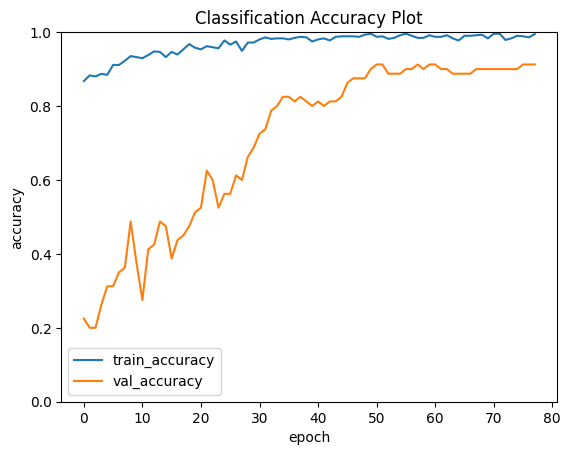

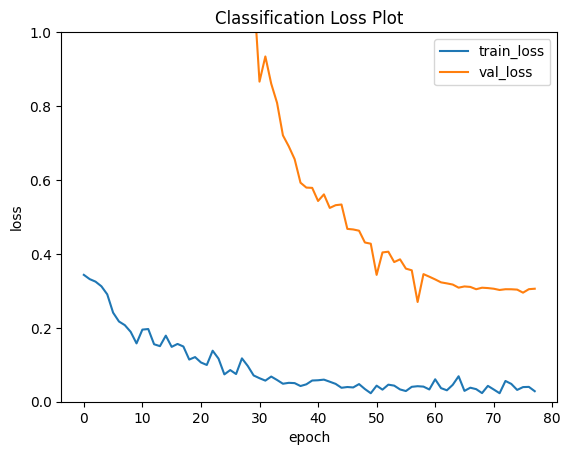

In [41]:
plot_accuracy(history, 'Classification Accuracy Plot')
plot_loss(history, 'Classification Loss Plot')

In [42]:

#model = create_model()
model.load_weights('/content/drive/MyDrive/FYPReport/weights/mobilenetv2_weights-58.h5')


In [43]:
# Assume the model.predict() call returns a predictions object
predictions = model.predict(test_generator, verbose=0)

# Getting the index of the highest probability class per image
y_pred = np.argmax(predictions, axis=1)

# Getting the true labels per image
y_true = test_generator.classes

# Getting the class names (labels) from the generator
class_names = list(test_generator.class_indices.keys())

# Printing the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.78      0.70      0.74        10
           2       0.83      0.91      0.87        11
           3       0.83      1.00      0.91        10
           4       0.90      0.90      0.90        10
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00        12
           7       1.00      0.92      0.96        12

    accuracy                           0.92        83
   macro avg       0.92      0.92      0.91        83
weighted avg       0.92      0.92      0.92        83



In [44]:

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

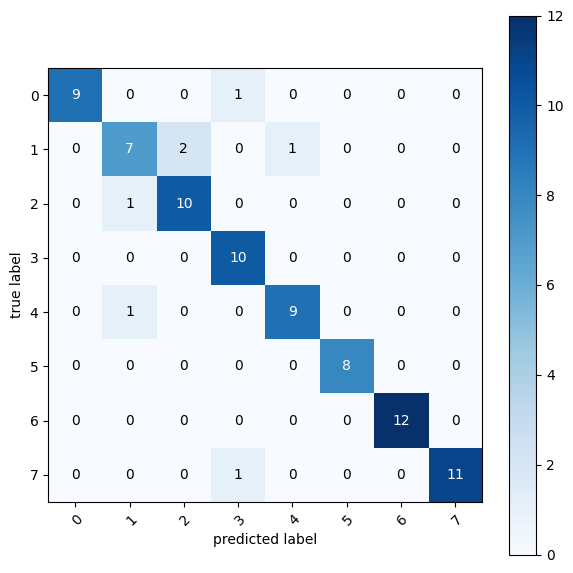

In [52]:
# Compute confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using mlxtend's `plot_confusion_matrix`
figure, ax = plot_confusion_matrix(conf_mat=cm,
                                   show_absolute=True,
                                   show_normed=False,
                                   colorbar=True,
                                   class_names=class_names,
                                   figsize=(7, 7))
plt.show()

Clear  below section after

In [46]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [47]:

mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [48]:
# Load the pre-trained MobileNet model
mobile = MobileNet()

In [49]:
# Take the output from the fifth-to-last layer of MobileNet
x = mobile.layers[-5].output


# Reshape the output to be 1D tensor with 1024 elements
x = Reshape(target_shape=(1024,))(x)


# Add a dense layer with 8 units and softmax activation for classification
output = Dense(units=8, activation='softmax')(x)


In [50]:
# Create a new model with the same input as MobileNet but with the new output layer
model = Model(inputs=mobile.input, outputs=output)



# Freeze all layers except the last 22 layers
for layer in model.layers[:-22]:
    layer.trainable = False


# Summary of the model to verify the architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [51]:
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

save_dir = '/content/drive/MyDrive/progress/For-Report/MobileNet_b=16-width-1'
os.makedirs(save_dir, exist_ok=True)
weights_dir = os.path.join(save_dir, 'weights')
os.makedirs(weights_dir, exist_ok=True)
logs_dir = os.path.join(save_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(weights_dir, 'MobileNet_weights-{epoch:02d}.h5'),
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [ ]:
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)

In [ ]:
csv_logger_callback = CSVLogger(
    os.path.join(logs_dir, 'training_log.csv')
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
callbacks = [
    model_checkpoint_callback,
    reduce_lr_callback,
    csv_logger_callback,
    early_stopping_callback
]

In [ ]:
# Create MobileNetV1 model with width multiplier
base_model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), alpha=WIDTH_MULTIPLIER, include_top=False, pooling='avg')
model = tf.keras.Sequential([
    base_model,
    Dense(8, activation='softmax')  # Change to 8 for tea leaf disease classification
])

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.1564 - categorical_accuracy: 0.9422
Epoch 1: val_loss did not improve from 0.21121
45/45 [==============================] - 201s 4s/step - loss: 0.1564 - categorical_accuracy: 0.9422 - val_loss: 0.2308 - val_categorical_accuracy: 0.9375 - lr: 1.0000e-08
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.1409 - categorical_accuracy: 0.9478
Epoch 2: val_loss did not improve from 0.21121
45/45 [==============================] - 179s 4s/step - loss: 0.1409 - categorical_accuracy: 0.9478 - val_loss: 0.2345 - val_categorical_accuracy: 0.9250 - lr: 1.0000e-08
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.1285 - categorical_accuracy: 0.9506
Epoch 3: val_loss did not improve from 0.21121
45/45 [==============================] - 177s 4s/step - loss: 0.1285 - categorical_accuracy: 0.9506 - val_loss: 0.2213 - val_categorical_accuracy: 0.9000 - lr: 1.0000e-08
Epoch 4/100
45/45 [======

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train_loss', 'val_loss'], loc='best')
    plt.show()

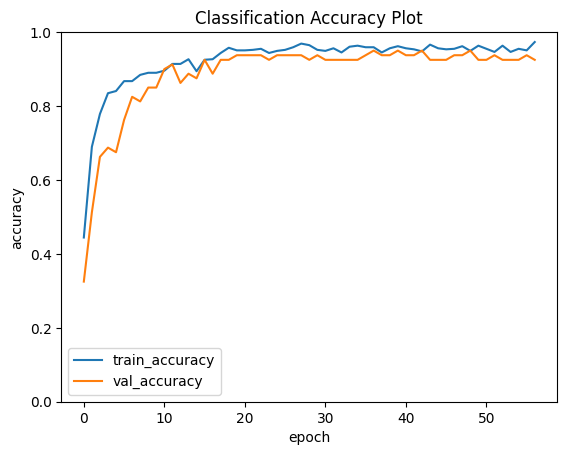

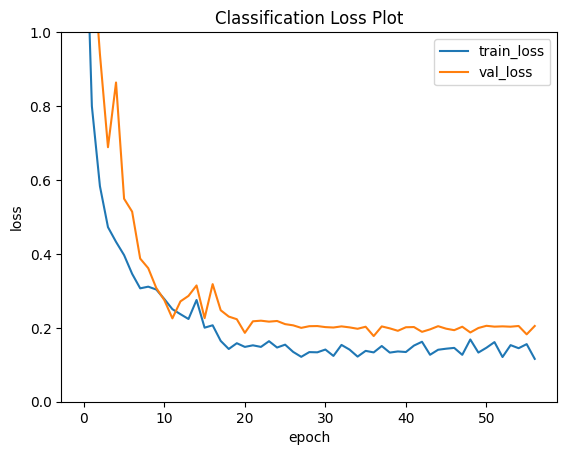

In [ ]:
plot_accuracy(history, 'Classification Accuracy Plot')
plot_loss(history, 'Classification Loss Plot')

In [ ]:

#model = create_model()
model.load_weights('/content/drive/MyDrive/progress/For-Report/MobileNet_b=16-width-0.75/weights/MobileNet_weights-37.h5')


In [ ]:
# Assume the model.predict() call returns a predictions object
predictions = model.predict(test_generator, verbose=0)

# Getting the index of the highest probability class per image
y_pred = np.argmax(predictions, axis=1)

# Getting the true labels per image
y_true = test_generator.classes

# Getting the class names (labels) from the generator
class_names = list(test_generator.class_indices.keys())

# Printing the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.88      0.70      0.78        10
           2       0.83      0.91      0.87        11
           3       0.89      0.80      0.84        10
           4       0.91      1.00      0.95        10
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00        12
           7       0.83      0.83      0.83        12

    accuracy                           0.90        83
   macro avg       0.91      0.91      0.90        83
weighted avg       0.90      0.90      0.90        83



In [ ]:

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

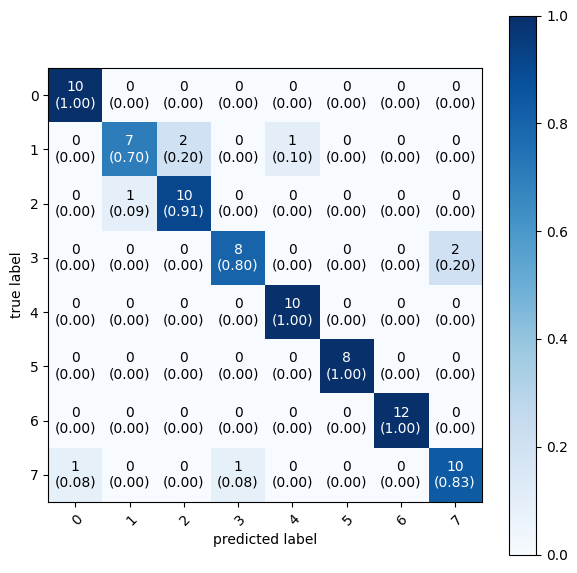

In [ ]:
# Compute confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using mlxtend's `plot_confusion_matrix`
figure, ax = plot_confusion_matrix(conf_mat=cm,
                                   show_absolute=True,
                                   show_normed=True,
                                   colorbar=True,
                                   class_names=class_names,
                                   figsize=(7, 7))
plt.show()